In [1]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score, classification_report

from keras import Model, Sequential
from keras import metrics
from keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [2]:
# carregar os dados de entrada
inputs_file = 'input_db_29_08_2023_14_26_20.pkl'
with open(inputs_file, 'rb') as handle_inputs:
    inputs = pickle.load(handle_inputs)

In [3]:
inputs.head()

,site_lat,site_long,sat_long,freq,eirp,hsat,bw_total,bw_util,rolloff,mod,fec,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,35786,36,16.155547,0.2,32APSK,126/180,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,35786,36,22.226415,0.2,32APSK,135/180,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518
2,-19.167619,-34.986496,-2.622435,5.349325,56.252903,35786,36,35.827805,0.2,64APSK,162/180,19.590329,1.207189,0.530488,57.036432,28.600282,5.894995,1.506105
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,35786,36,14.203504,0.2,8PSK,100/180,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,35786,36,9.488156,0.2,32APSK,126/180,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052


In [4]:
inputs = inputs.drop(columns=["hsat", "bw_total", "mod", "fec", "rolloff"])

In [5]:
# carregar os dados de saída - 
# apenas a coluna availability é relevante para o problema, 
# pode-se ignorar as demais para o treinamento e teste
results_file = 'results_db_29_08_2023_14_26_20.pkl'
with open(results_file, 'rb') as handle_results:
    results = pickle.load(handle_results)

In [6]:
results.head()

,availability,a_fs,a_g,a_c,a_r,a_s,a_t,a_tot,a_depoint,c_n0,...,earth_radius,elevation_angle,distance,fig_merit,noise_ground,noise_sky,ant_noise,noise_total,ant_gain,ant_3db
0,99.904,207.841452,0.322924,0.966845,9.079432,0.526741,10.383000,220.241483,2.017030,84.759447,...,6367.489544,43.741256,37499.215397,24.276649,10.0,10.860506,260.815713,286.308799,43.398944,1.263074
1,99.999,201.903879,0.065287,0.201974,7.102761,0.439884,7.383255,277.812514,68.525380,112.688241,...,6367.489544,56.474767,36698.322584,95.134206,10.0,3.208548,235.351027,248.680367,46.873483,0.591097
2,96.460,198.393586,0.065097,0.039061,0.016178,0.116006,0.193583,201.164695,2.577525,-99916.332614,...,6367.489544,47.007765,37271.796260,-100000.000000,10.0,3.867110,25.687222,54.289160,33.854824,3.249709
3,99.999,206.567603,0.201870,0.712902,27.381892,0.930295,28.312062,241.951596,7.071931,86.145051,...,6367.489544,59.412644,36547.299501,23.855004,10.0,5.183472,284.602019,314.728183,39.509835,1.408672
4,99.990,207.986262,0.381950,1.032110,16.817812,0.716087,18.246230,232.308445,6.075953,82.544269,...,6367.489544,37.330831,37986.968867,26.033504,10.0,12.583786,281.070225,302.118263,43.249134,0.517240


In [7]:
# preprocessamento da base de dados - 
# as linhas cuja coluna fig_merit têm valor igual a -100000 
# são casos inválidos e devem ser removidos 
filter_matrix = results.fig_merit != -100000
print(filter_matrix.head())
print(np.sum(filter_matrix))

0     True
1     True
2    False
3     True
4     True
Name: fig_merit, dtype: bool
1457619


In [8]:
filtered_inputs = inputs[filter_matrix]
filtered_results = results[filter_matrix]

In [9]:
print(filtered_inputs.shape)
print(inputs.shape)

print(filtered_results.shape)
print(results.shape)

(1457619, 13)
(1880000, 13)
(1457619, 21)
(1880000, 21)


           site_lat     site_long      sat_long          freq          eirp  \
count  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean  -1.505471e+01 -5.330440e+01 -5.230916e+01  1.132981e+01  5.091215e+01   
std    1.061157e+01  1.080609e+01  3.258509e+01  4.041949e+00  1.763086e+01   
min   -3.368997e+01 -7.288998e+01 -1.079999e+02  3.000049e+00  1.500033e+01   
25%   -2.430390e+01 -6.240066e+01 -8.093161e+01  7.965716e+00  3.691857e+01   
50%   -1.470179e+01 -5.317498e+01 -5.223987e+01  1.150008e+01  5.183633e+01   
75%   -5.817384e+00 -4.398199e+01 -2.366515e+01  1.483480e+01  6.597661e+01   
max    2.819986e+00 -3.480004e+01  2.999920e+00  1.799999e+01  7.999994e+01   

            bw_util  snr_threshold      ant_size       ant_eff      lnb_gain  \
count  1.457619e+06   1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean   1.850569e+01   8.798743e+00  2.383836e+00  5.565397e-01  5.999881e+01   
std    1.009771e+01   5.843946e+00  1.251949e+00

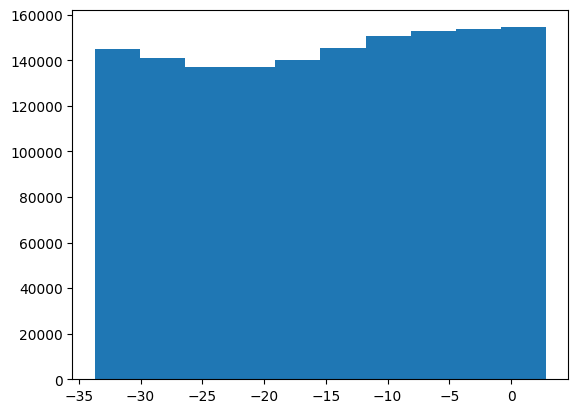

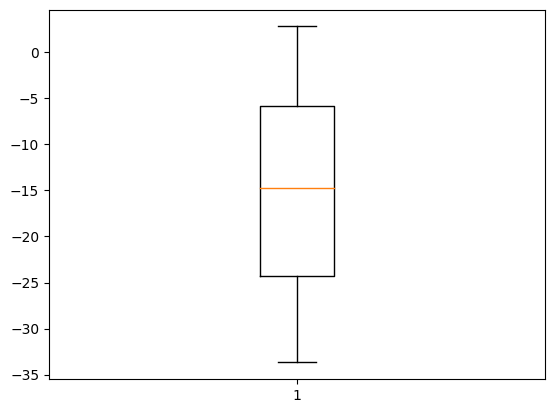

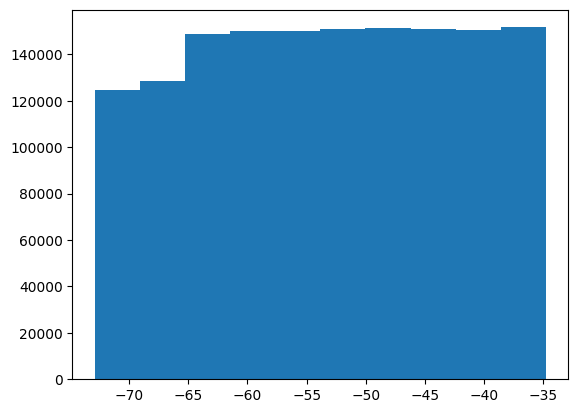

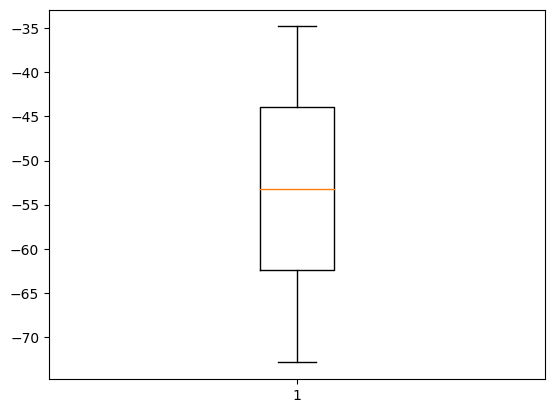

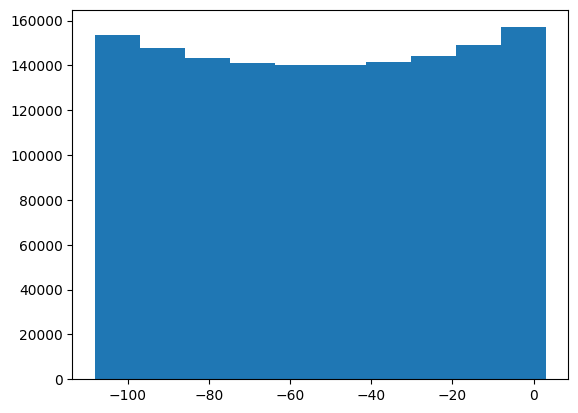

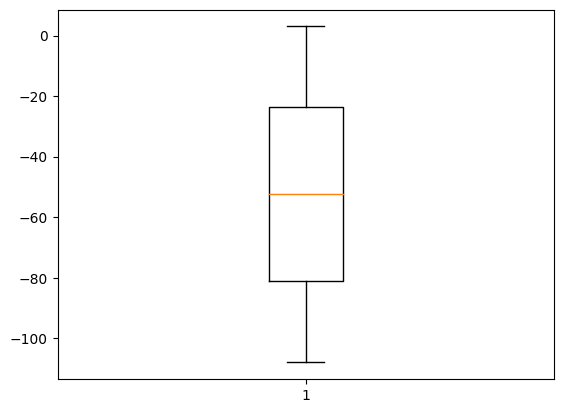

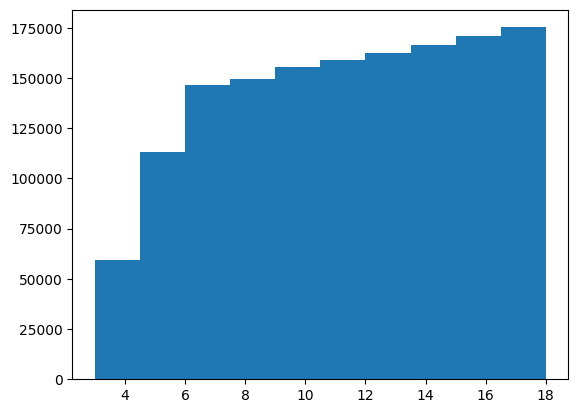

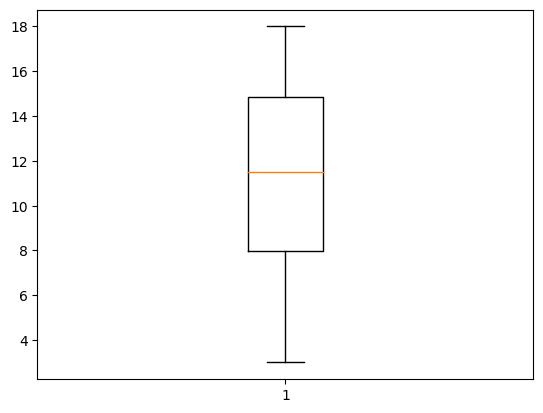

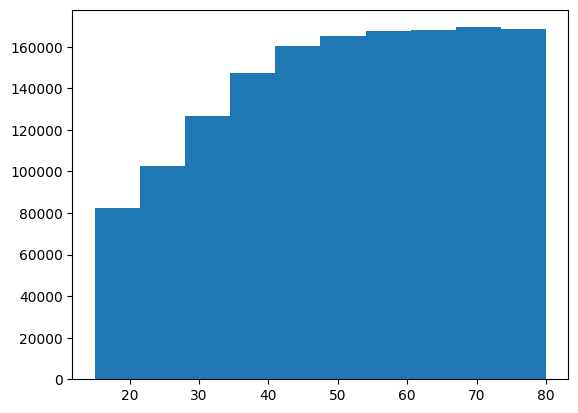

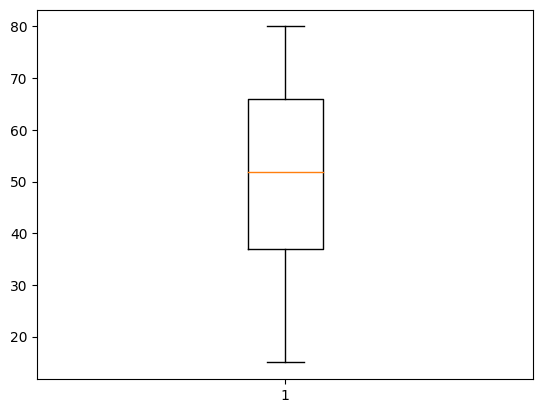

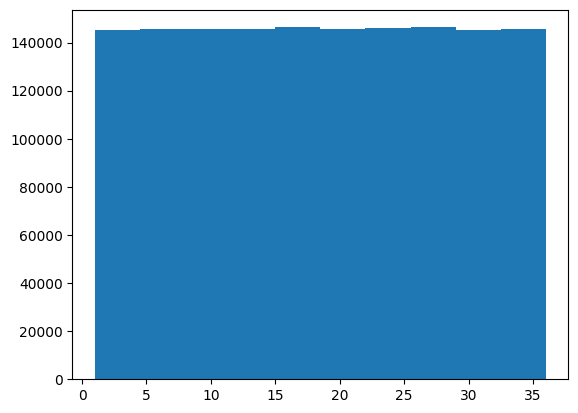

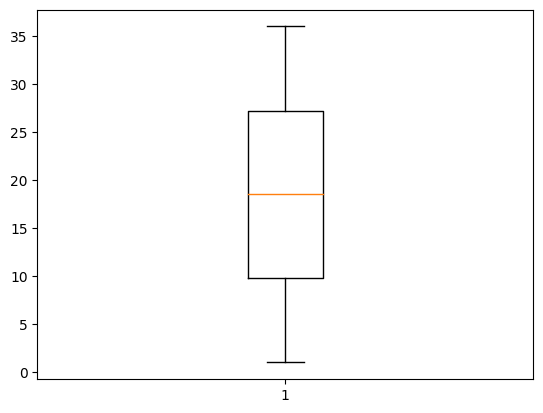

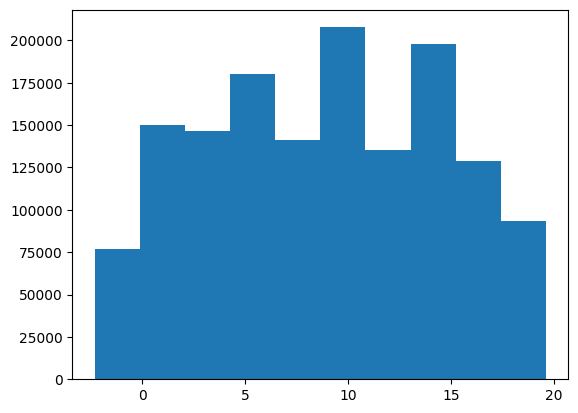

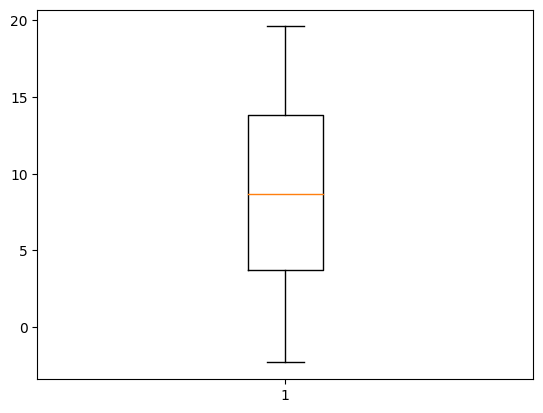

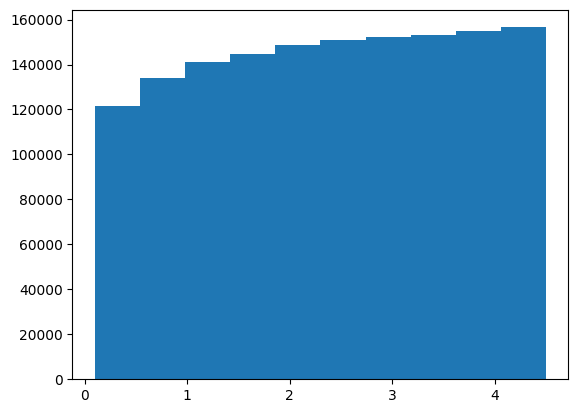

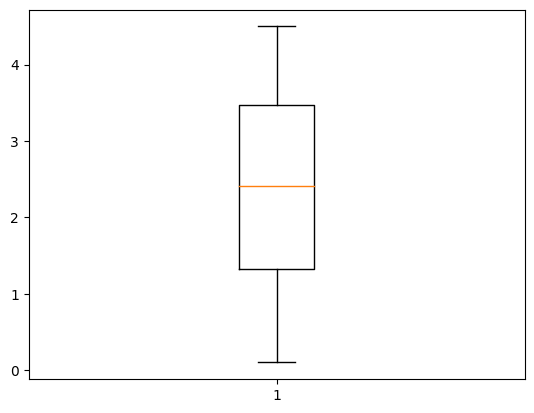

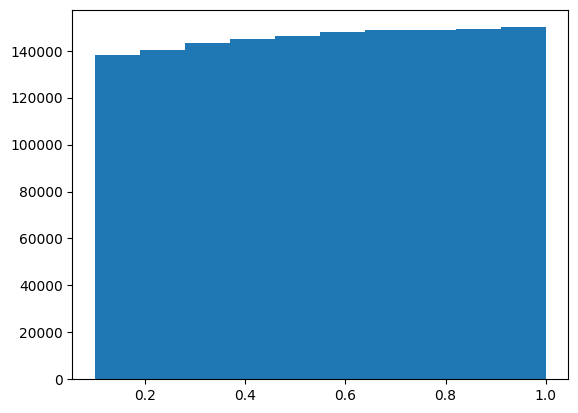

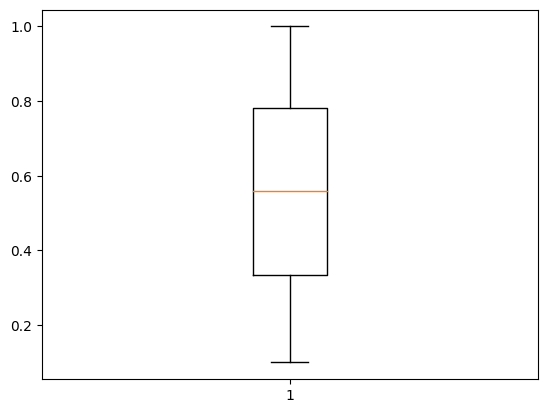

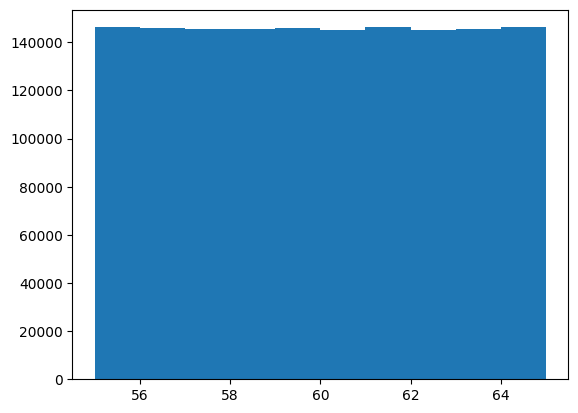

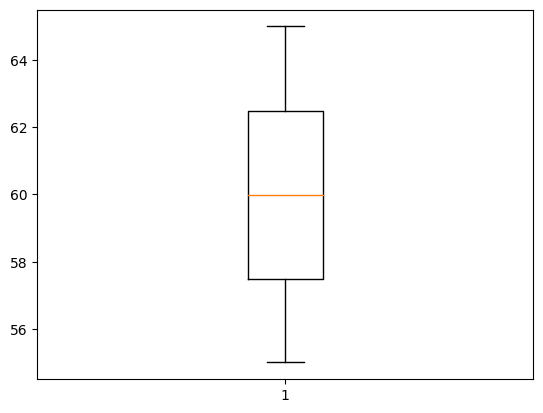

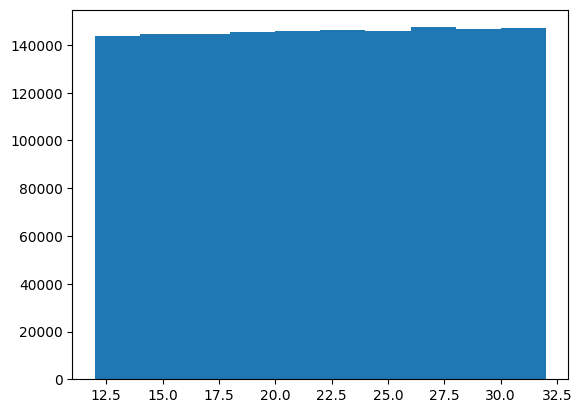

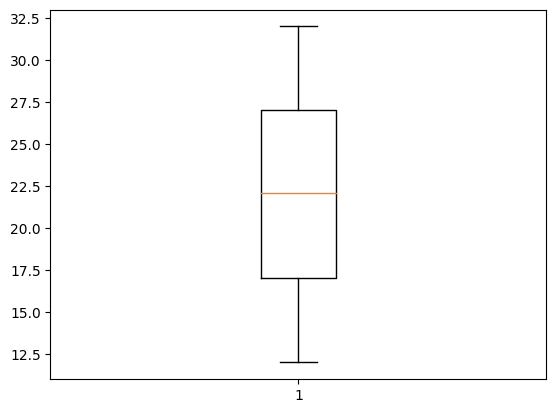

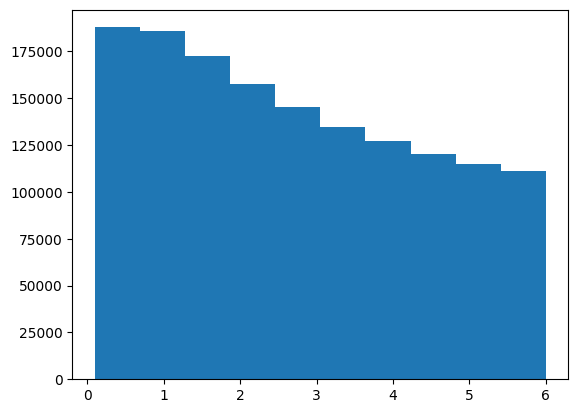

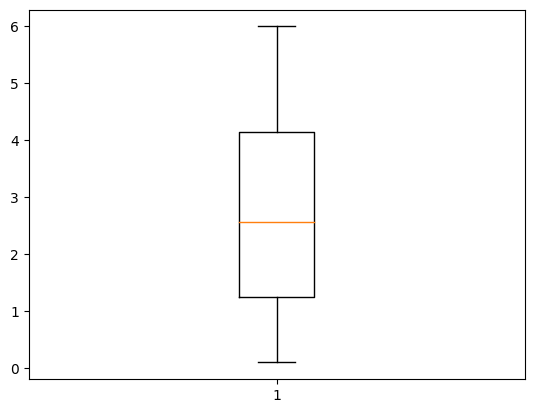

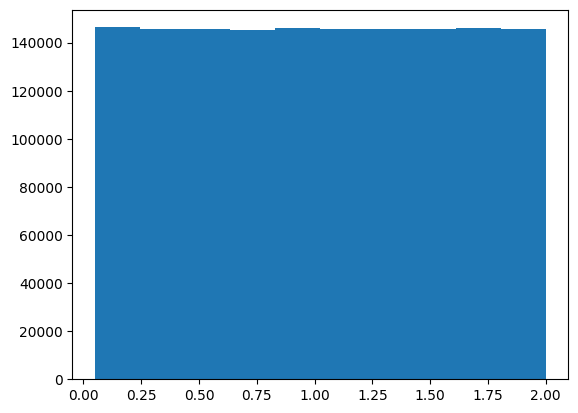

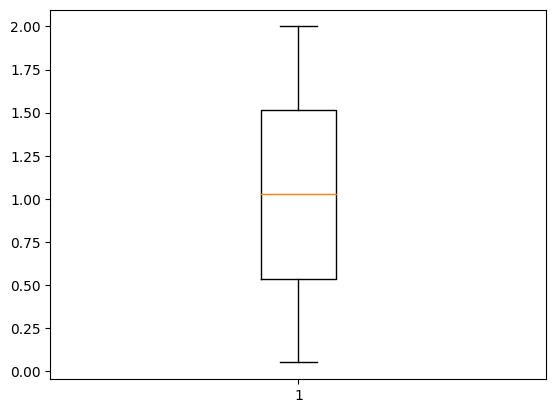

In [10]:
print(filtered_inputs.describe())
for column in inputs.columns:
    # Creating plot
    plt.hist(filtered_inputs[column])
    plt.show()
    plt.boxplot(filtered_inputs[column])
    plt.show()

In [11]:
df = filtered_inputs.assign(availability=filtered_results["availability"])
df.head()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,16.155547,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839,99.904
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,22.226415,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518,99.999
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,14.203504,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404,99.999
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,9.488156,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052,99.990
5,-17.303467,-41.668725,-66.343144,12.480028,27.720772,31.814645,8.326742,4.452849,0.583401,64.208048,17.289375,2.862834,1.010339,99.554


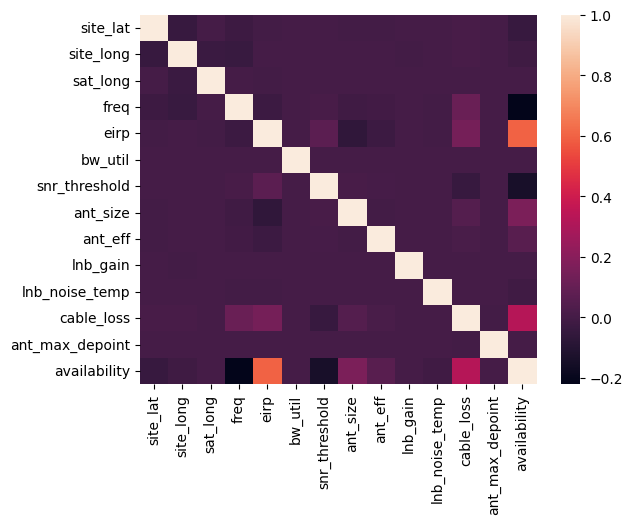

In [12]:
sns.heatmap(df.corr())
plt.show()

In [13]:
df_majority_data = df[df['availability'] >= 99.5]
df_minority_data = df[df['availability'] < 99.5]

In [14]:
df_minority_data.count()

site_lat           333973
site_long          333973
sat_long           333973
freq               333973
eirp               333973
bw_util            333973
snr_threshold      333973
ant_size           333973
ant_eff            333973
lnb_gain           333973
lnb_noise_temp     333973
cable_loss         333973
ant_max_depoint    333973
availability       333973
dtype: int64

In [15]:
df_data_undersample = df_majority_data.sample(int(df_minority_data['availability'].count()/2))

In [16]:
df_balanced = pd.concat([df_data_undersample, df_minority_data], axis=0)
print(df_balanced.head())
df_balanced.describe()

          site_lat  site_long    sat_long      freq       eirp    bw_util  \
968977  -20.065244 -43.479768 -100.651720  6.444463  35.979212  25.223145   
242148  -13.690717 -68.744362 -100.233208  5.042011  77.368737  18.596208   
1180722 -20.183635 -45.931538  -94.069021  8.160609  57.210767  13.968038   
204334   -8.000469 -55.130639  -83.730232  5.583889  55.210417   1.009273   
1465469  -6.277467 -70.487563  -88.564696  5.788009  48.831507  22.075844   

         snr_threshold  ant_size   ant_eff   lnb_gain  lnb_noise_temp  \
968977       10.179462  3.710846  0.224271  58.325481       29.932948   
242148       13.828307  2.798758  0.749058  63.866653       22.160945   
1180722       4.395135  3.937676  0.363749  55.161136       15.673046   
204334        9.101579  0.739643  0.349006  60.719970       19.422253   
1465469      -2.297824  3.017894  0.881078  64.787290       24.370768   

         cable_loss  ant_max_depoint  availability  
968977     2.223234         1.495140        9

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
count,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000
mean,-14.413815,-53.063037,-52.315970,12.372214,39.986988,18.498248,9.594322,2.190240,0.541865,60.001351,22.103164,2.231847,1.024479,98.018382
std,10.656330,10.695695,33.547966,3.948480,17.169792,10.095453,5.800337,1.280733,0.260429,2.888915,5.769289,1.585532,0.562989,1.735495
min,-33.689911,-72.889841,-107.999154,3.000081,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000111,0.100010,0.050018,95.000000
25%,-23.680329,-61.997792,-82.580854,9.417895,26.056653,9.745948,5.134135,1.062777,0.315005,57.503222,17.121894,0.891929,0.536377,96.350000
50%,-13.611822,-52.877987,-52.228823,13.040678,36.672785,18.517730,9.605005,2.138711,0.537806,59.996231,22.151100,1.876119,1.024289,98.276000
75%,-5.036386,-43.845070,-22.045895,15.768296,51.441476,27.231076,14.211092,3.291490,0.766477,62.503041,27.111831,3.344422,1.512007,99.976000
max,2.819986,-34.800075,2.999920,17.999990,79.999936,35.999969,19.590329,4.499999,0.999999,64.999992,31.999870,5.999996,1.999997,99.999000


In [17]:
x = df_balanced.drop('availability',axis='columns')
y = df_balanced['availability']

In [18]:
# setando a semente para divisão dos conjuntos de treino e teste
np.random.seed(0)

In [19]:
# separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [20]:
# alguns dados estatisticos por atributo
x_train.describe()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
count,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000
mean,-14.425502,-53.064452,-52.299461,12.374213,39.981987,18.487036,9.589504,2.189775,0.541979,60.000758,22.099909,2.233626,1.024402
std,10.658432,10.698683,33.543074,3.951210,17.177979,10.089545,5.801429,1.280734,0.260497,2.889477,5.767925,1.585707,0.563283
min,-33.689833,-72.889841,-107.999154,3.000081,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000111,0.100010,0.050036
25%,-23.699884,-62.007941,-82.551567,9.417074,26.040621,9.750589,5.134135,1.062413,0.315076,57.502236,17.121441,0.893798,0.535334
50%,-13.626682,-52.871702,-52.183754,13.047000,36.659427,18.498219,9.605005,2.137867,0.538017,59.996823,22.150020,1.878802,1.024866
75%,-5.050339,-43.847087,-22.062648,15.771061,51.449494,27.215903,14.211092,3.289527,0.766766,62.503292,27.103793,3.345460,1.512721
max,2.819986,-34.800075,2.999920,17.999983,79.999936,35.999969,19.590329,4.499999,0.999999,64.999992,31.999782,5.999996,1.999988


In [21]:
y_train.describe()

count    400767.000000
mean         98.018735
std           1.735165
min          95.000000
25%          96.350000
50%          98.280000
75%          99.976000
max          99.999000
Name: availability, dtype: float64

(array([ 13831.,  43687.,  61486.,  62960.,   5563.,   8005.,  11354.,
         17201.,  43185., 133495.]),
 array([95.    , 95.4999, 95.9998, 96.4997, 96.9996, 97.4995, 97.9994,
        98.4993, 98.9992, 99.4991, 99.999 ]),
 <BarContainer object of 10 artists>)

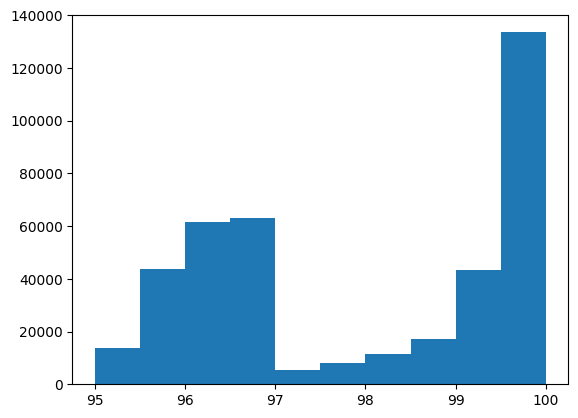

In [22]:
plt.hist(y_train)

In [23]:
y_test.describe()

count    100192.000000
mean         98.016972
std           1.736824
min          95.000000
25%          96.340000
50%          98.221000
75%          99.977000
max          99.999000
Name: availability, dtype: float64

(array([ 3520., 11091., 15085., 15827.,  1373.,  2093.,  2823.,  4213.,
        10676., 33491.]),
 array([95.    , 95.4999, 95.9998, 96.4997, 96.9996, 97.4995, 97.9994,
        98.4993, 98.9992, 99.4991, 99.999 ]),
 <BarContainer object of 10 artists>)

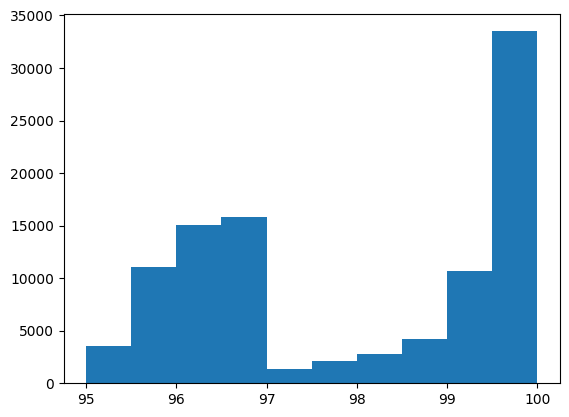

In [24]:
plt.hist(y_test)

In [25]:
# normalização dos dados
preprocessParams = preprocessing.StandardScaler().fit(x_train)
x_train_normalized = preprocessParams.transform(x_train)
x_test_normalized = preprocessParams.transform(x_test)

In [26]:
y_train_num = pd.to_numeric(y_train)
y_train_df = pd.DataFrame(y_train_num)
y_test_num = pd.to_numeric(y_test)
y_test_df = pd.DataFrame(y_test_num)

preprocessParamsY = preprocessing.StandardScaler().fit(y_train_df)
y_train_normalized = preprocessParamsY.transform(y_train_df)
y_test_normalized = preprocessParamsY.transform(y_test_df)

(array([ 13831.,  43687.,  61486.,  62960.,   5563.,   8005.,  11354.,
         17201.,  43185., 133495.]),
 array([-1.73974181, -1.45164202, -1.16354224, -0.87544245, -0.58734267,
        -0.29924288, -0.0111431 ,  0.27695669,  0.56505647,  0.85315626,
         1.14125604]),
 <BarContainer object of 10 artists>)

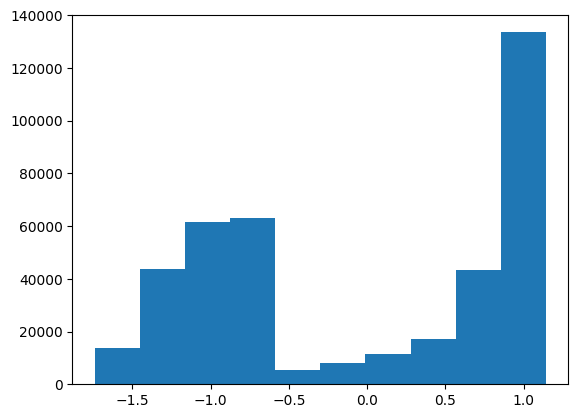

In [27]:
plt.hist(y_train_normalized)

(array([ 3520., 11091., 15085., 15827.,  1373.,  2093.,  2823.,  4213.,
        10676., 33491.]),
 array([-1.73974181, -1.45164202, -1.16354224, -0.87544245, -0.58734267,
        -0.29924288, -0.0111431 ,  0.27695669,  0.56505647,  0.85315626,
         1.14125604]),
 <BarContainer object of 10 artists>)

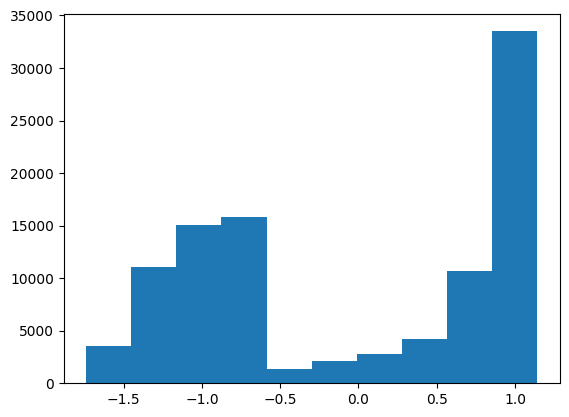

In [28]:
plt.hist(y_test_normalized)

In [29]:
x_train_normalized.shape[1:]

(13,)

In [30]:
# teste de rede neural
RN = Sequential()
RN.add(Dense(256, input_shape = x_train_normalized.shape[1:], activation = 'sigmoid'))
RN.add(Dropout(0.05))
RN.add(Dense(128, activation = 'sigmoid'))
RN.add(Dropout(0.05))
RN.add(Dense(1))
RN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36609 (143.00 KB)
Trainable params: 36609 (143.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# treinamento
RN.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mape', 'mae', 'msle', 'log_cosh', 'cosine_proximity']) 
history = RN.fit(x_train_normalized, y_train_normalized, epochs=200, validation_split=0.2)

Epoch 1/200
10020/10020 [==============================] - 8s 736us/step - loss: 0.2433 - mape: 61.1925 - mae: 0.3459 - msle: 0.0336 - log_cosh: 0.1047 - cosine_proximity: 0.7861 - val_loss: 0.2010 - val_mape: 55.6850 - val_mae: 0.2922 - val_msle: 0.0243 - val_log_cosh: 0.0861 - val_cosine_proximity: 0.8195
Epoch 2/200
10020/10020 [==============================] - 7s 721us/step - loss: 0.1764 - mape: 53.1719 - mae: 0.2863 - msle: 0.0219 - log_cosh: 0.0767 - cosine_proximity: 0.8418 - val_loss: 0.1221 - val_mape: 42.7703 - val_mae: 0.2299 - val_msle: 0.0131 - val_log_cosh: 0.0543 - val_cosine_proximity: 0.8939
Epoch 3/200
10020/10020 [==============================] - 7s 719us/step - loss: 0.1262 - mape: 44.2400 - mae: 0.2445 - msle: 0.0142 - log_cosh: 0.0563 - cosine_proximity: 0.8935 - val_loss: 0.1010 - val_mape: 38.5257 - val_mae: 0.2065 - val_msle: 0.0102 - val_log_cosh: 0.0453 - val_cosine_proximity: 0.9162
Epoch 4/200
10020/10020 [==============================] - 7s 723us/step 

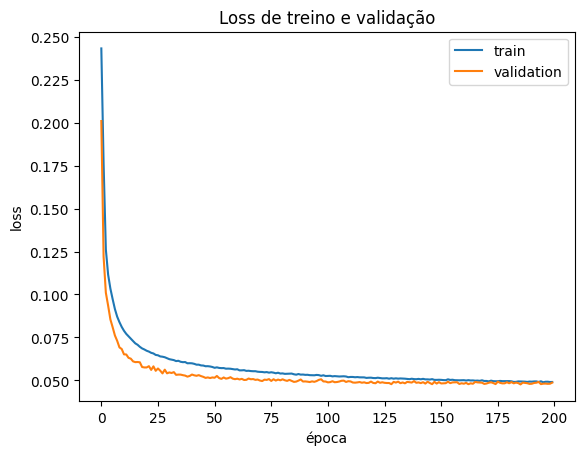

In [32]:
# gráfico do treinamento: custo do treino e validação
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss de treino e validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

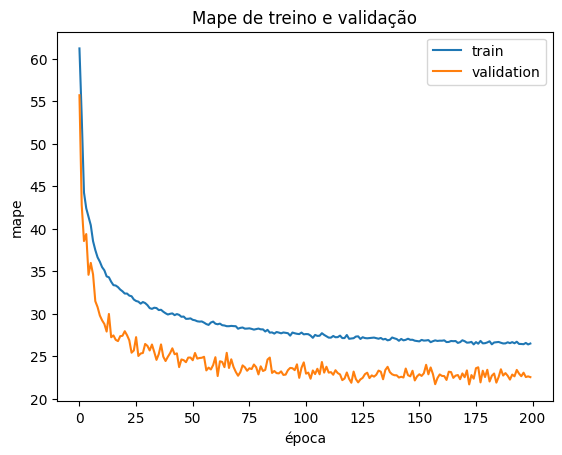

In [33]:
# gráfico do treinamento: mape do treino e validação
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('Mape de treino e validação')
plt.ylabel('mape')
plt.xlabel('época')
plt.legend();

In [34]:
# avaliação
score = RN.evaluate(x_train_normalized, y_train_normalized, verbose = 0)
print('Train score:', score[0])
print('Train mape:', score[1], '%')

Train score: 0.04214625433087349
Train mape: 21.393110275268555 %


In [35]:
# avaliação
score = RN.evaluate(x_test_normalized, y_test_normalized, verbose = 0)
print('Test score:', score[0])
print('Test mape:', score[1], '%')

Test score: 0.04937653988599777
Test mape: 23.060842514038086 %


12524/12524 [==============================] - 3s 261us/step


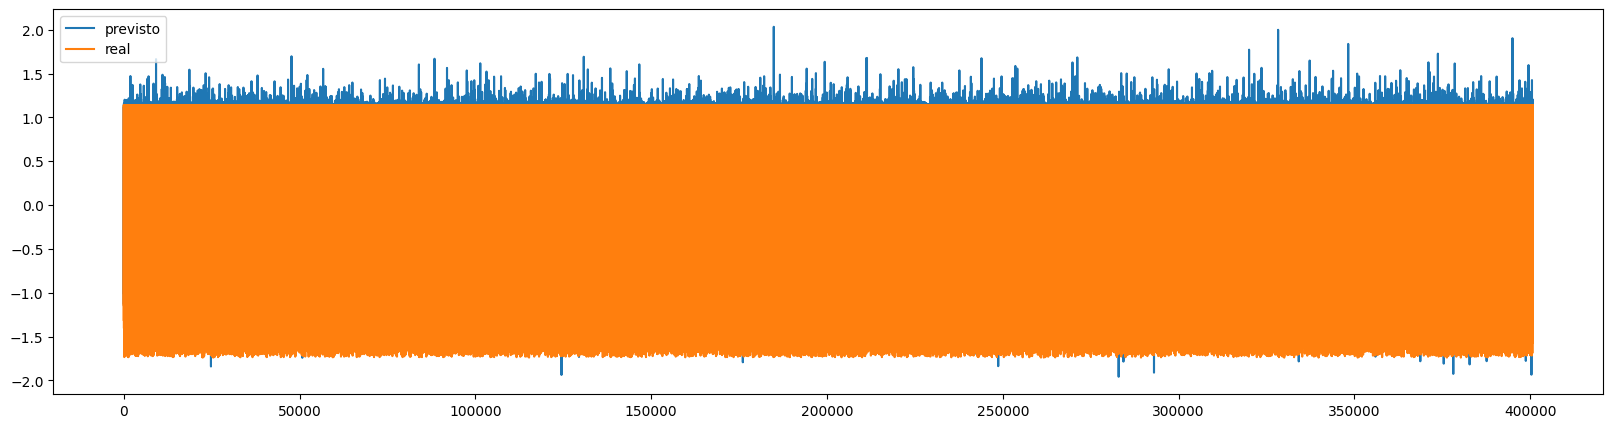

In [36]:
# avaliação gráfica
y_train_predicted = RN.predict(x_train_normalized)

results_train = pd.DataFrame(y_train_predicted, columns = ['previsto'])
results_train['real'] = np.array(y_train_normalized)
results_train.plot(figsize=(20,5)); # todas as previsões

3131/3131 [==============================] - 1s 287us/step


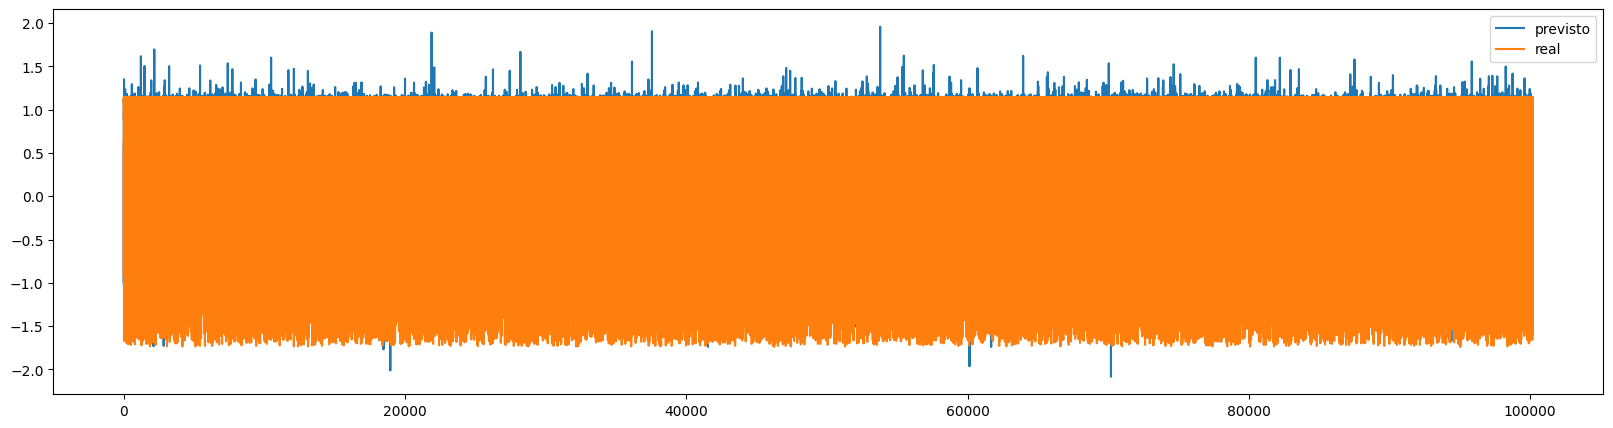

In [37]:
# avaliação gráfica
y_test_predicted = RN.predict(x_test_normalized)

results = pd.DataFrame(y_test_predicted, columns = ['previsto'])
results['real'] = np.array(y_test_normalized)
results.plot(figsize=(20,5)); # todas as previsões

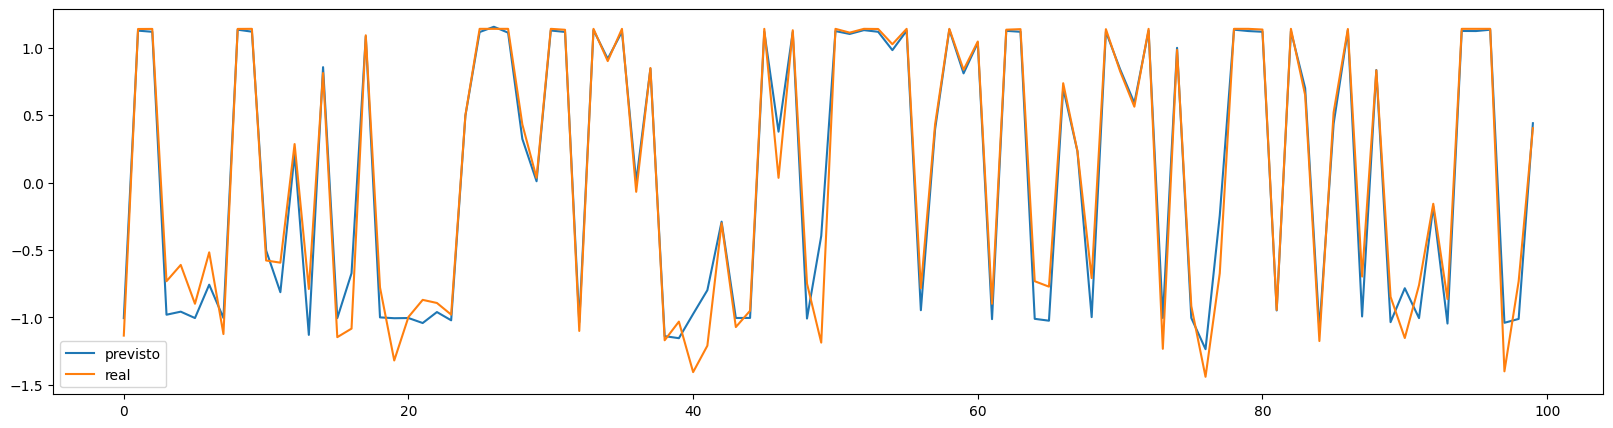

In [38]:
results_train.iloc[0:100,:].plot(figsize=(20,5)); # somente as 100 primeiras

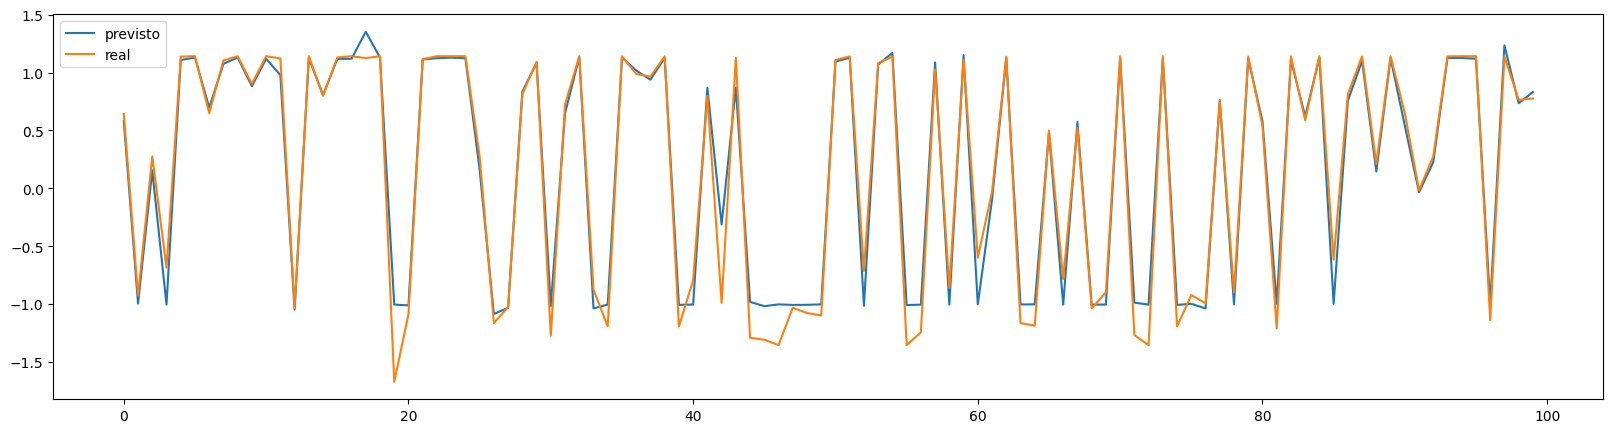

In [39]:
results.iloc[0:100,:].plot(figsize=(20,5)); # somente as 100 primeiras

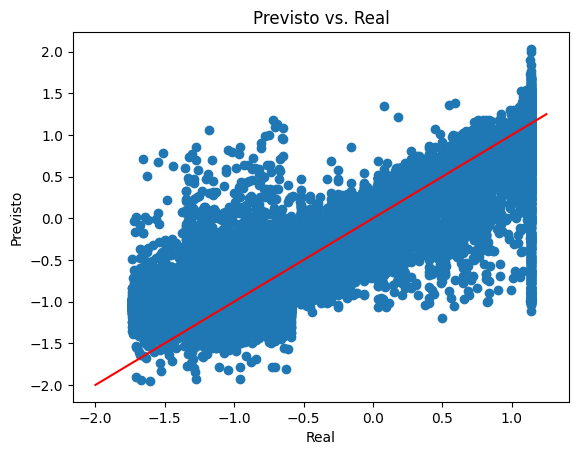

In [40]:
plt.scatter(x=y_train_normalized, y=y_train_predicted)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [-2, 1.25]
plt.plot(x, x, color='red'); # reta onde y=x

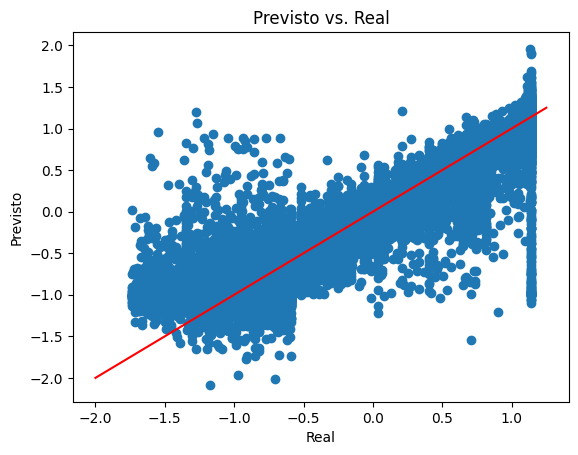

In [41]:
plt.scatter(x=y_test_normalized, y=y_test_predicted)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [-2, 1.25]
plt.plot(x, x, color='red'); # reta onde y=x

In [42]:
r2_score(y_train_normalized, y_train_predicted)

0.9578537819217753

In [43]:
r2_score(y_test_normalized, y_test_predicted)

0.9507174002652161

In [44]:
#desnormalizando e checando os valores de novo:
y_train_predicted_denorm = preprocessParamsY.inverse_transform(y_train_predicted)
y_test_predicted_denorm = preprocessParamsY.inverse_transform(y_test_predicted)

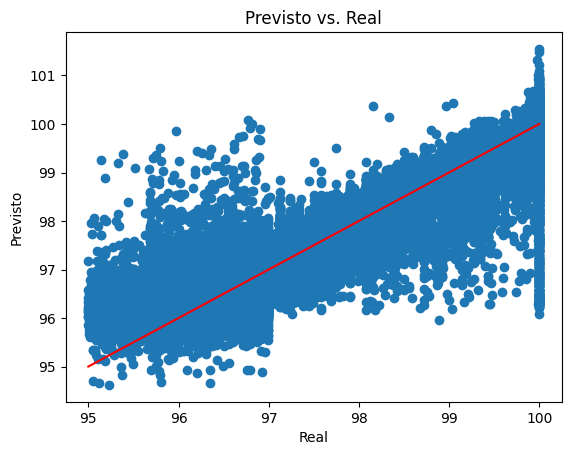

In [45]:
plt.scatter(x=y_train, y=y_train_predicted_denorm)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [95, 100]
plt.plot(x, x, color='red'); # reta onde y=x

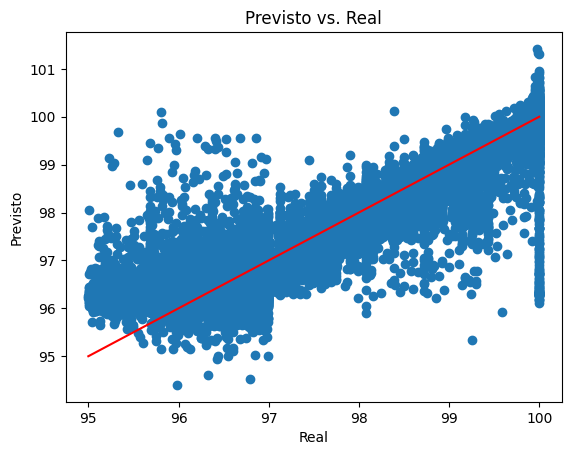

In [47]:
plt.scatter(x=y_test, y=y_test_predicted_denorm)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [95, 100]
plt.plot(x, x, color='red'); # reta onde y=x

In [48]:
r2_score(y_train, y_train_predicted_denorm)

0.9578537814817376

In [49]:
r2_score(y_test, y_test_predicted_denorm)

0.9507174006684151